In [1]:
# Some pre-requisites
# !pip install opencv-python
# !pip install scikit-image

In [2]:
import numpy as np
import os
from skimage.transform import resize as imresize
from cv2 import imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
# tf.set_random_seed(30)

In [4]:
data_loc = "Project_data"
train_doc = np.random.permutation(open(data_loc + '/train.csv').readlines())
val_doc = np.random.permutation(open(data_loc+'/val.csv').readlines())

In [5]:
batch_size = 8 # The experiment was also tried with batch 16 and 32 but due to gpu exhaustion we limited ourselves to 8


## Generator

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.


In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,2))
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(100,100))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        remaining = len(t) % batch_size
        print(remaining)
        if remaining != 0:
            batch_data = np.zeros((remaining,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*remaining)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*remaining)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(100,100))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255                    
                batch_labels[folder, int(t[folder + (batch*remaining)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [7]:
train_path = data_loc+'/train'
val_path = data_loc+'/val'

In [8]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [9]:
testGen = generator(train_path,train_doc,batch_size)

In [10]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)

Source path =  Project_data/train ; batch size = 8


In [11]:
batch_data.shape

(8, 15, 100, 100, 3)

In [12]:
inputShape = batch_data[0].shape
inputShape

(15, 100, 100, 3)

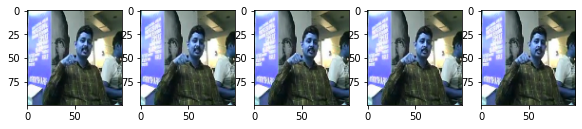

In [13]:
#Checking the input images
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
for i in range(1,6):
  ax = plt.subplot(2,10, i)
  plt.imshow(batch_data[2][i-1])

In [14]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10



## Model

Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.


In [15]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
#import tensorflow as tf
print(tf.test.gpu_device_name())
from keras.applications import mobilenet #for transfer learning
#write your model here

/device:GPU:0


In [18]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [16]:
from tensorflow.keras import backend as K
K.clear_session()

## Model 1 (Using Conv3D) Basic model

In [17]:
Input_shape = inputShape
model = Sequential()
model.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=Input_shape))
#model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.2))


model.add(Conv3D(32, (3, 3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.2))

model.add(Conv3D(64, (3, 3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(128,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(5))
model.add(Activation('softmax'))

In [18]:
optimiser =Adam(0.001) 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 15, 100, 100, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 50, 50, 16)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 50, 50, 16)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 50, 50, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 7, 50, 50, 32)     0         
                                                        

In [19]:
# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [20]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [LR]

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [22]:
steps_per_epoch

83

In [23]:
history_basic = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 8
Epoch 1/10
83/83 [==============================] - ETA: 0s - loss: 2.0718 - categorical_accuracy: 0.2323Source path =  Project_data/val ; batch size = 8
4
83/83 [==============================] - 187s 2s/step - loss: 2.0718 - categorical_accuracy: 0.2323 - val_loss: 1.7647 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/10
83/83 [==============================] - 139s 2s/step - loss: 1.4130 - categorical_accuracy: 0.4932 - val_loss: 1.1671 - val_categorical_accuracy: 0.5500 - lr: 0.0010
Epoch 3/10
83/83 [==============================] - 133s 2s/step - loss: 1.1605 - categorical_accuracy: 0.5747 - val_loss: 0.9638 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 4/10
83/83 [==============================] - 133s 2s/step - loss: 0.8944 - categorical_accuracy: 0.6621 - val_loss: 0.8068 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 5/10
83/83 [==============================] - 95s 1s/step - loss: 0.7469 - categorical

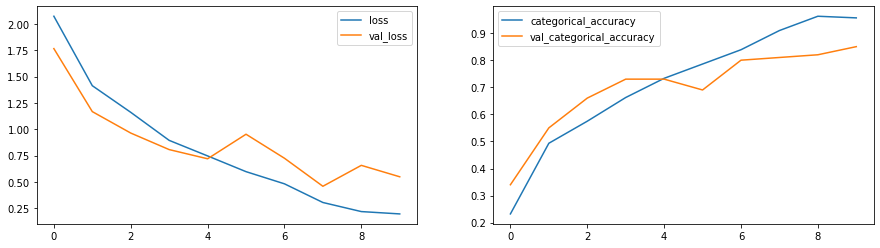

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
plot(history_basic)

## Model 2 (Using Conv3D)

In [25]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)
inputShape = batch_data[0].shape
inputShape

Source path =  Project_data/train ; batch size = 8


(15, 100, 100, 3)

In [26]:
train_path = data_loc+'/train'
val_path = data_loc+'/val'
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)



Input_shape = inputShape
model_2 = Sequential()
model_2.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=Input_shape))
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2, 2,2)))
model_2.add(Dropout(0.2))


model_2.add(Conv3D(32, (3, 3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2, 2,2)))
model_2.add(Dropout(0.2))

model_2.add(Conv3D(64, (3, 3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2, 2,2)))
model_2.add(Dropout(0.2))



model_2.add(Flatten())
model_2.add(Dense(64,kernel_regularizer=l2(0.01)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(128,kernel_regularizer=l2(0.01)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.3))

model_2.add(Dense(5))
model_2.add(Activation('softmax'))

optimiser =Adam(0.001) #write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

# training sequences = 663
# validation sequences = 100
# epochs = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_6 (Activation)   (None, 15, 100, 100, 16)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 7, 50, 50, 16)     0         
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 50, 50, 32)     13856     
                                                                 
 activation_7 (Activation)   (None, 7, 50, 50, 32)

In [27]:
# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)



model_name = 'Model_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
 

history_2 = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)    

Source path =  Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 2.7956 - categorical_accuracy: 0.2112Source path =  Project_data/val ; batch size = 8
4

Epoch 00001: val_loss improved from inf to 2.23362, saving model to Model_2_2021-12-2511_21_08.088553\model-00001-2.79559-0.21116-2.23362-0.17000.h5
83/83 [==============================] - 63s 759ms/step - loss: 2.7956 - categorical_accuracy: 0.2112 - val_loss: 2.2336 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.9983 - categorical_accuracy: 0.26094

Epoch 00002: val_loss improved from 2.23362 to 1.76203, saving model to Model_2_2021-12-2511_21_08.088553\model-00002-1.99828-0.26094-1.76203-0.34000.h5
83/83 [==============================] - 63s 762ms/step - loss: 1.9983 - categorical_accuracy: 0.2609 - val_loss: 1.7620 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 3/20
83/83 [==========================

Epoch 17/20
83/83 [==============================] - ETA: 0s - loss: 0.4568 - categorical_accuracy: 0.91104

Epoch 00017: val_loss did not improve from 0.60458

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
83/83 [==============================] - 61s 749ms/step - loss: 0.4568 - categorical_accuracy: 0.9110 - val_loss: 0.8086 - val_categorical_accuracy: 0.8200 - lr: 5.0000e-04
Epoch 18/20
83/83 [==============================] - ETA: 0s - loss: 0.4231 - categorical_accuracy: 0.91554

Epoch 00018: val_loss improved from 0.60458 to 0.45388, saving model to Model_2_2021-12-2511_21_08.088553\model-00018-0.42310-0.91554-0.45388-0.91000.h5
83/83 [==============================] - 63s 764ms/step - loss: 0.4231 - categorical_accuracy: 0.9155 - val_loss: 0.4539 - val_categorical_accuracy: 0.9100 - lr: 2.5000e-04
Epoch 19/20
83/83 [==============================] - ETA: 0s - loss: 0.3603 - categorical_accuracy: 0.94724

Epoch 00019: val_loss did not improve from

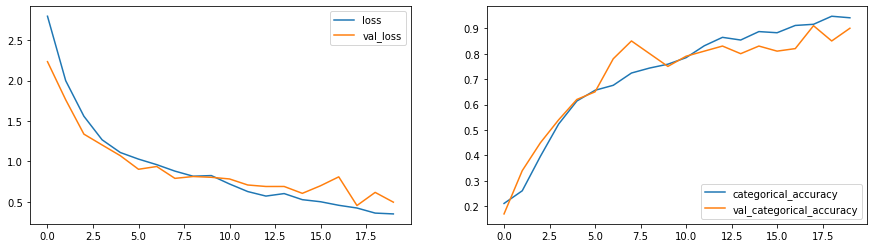

In [28]:
plot(history_2)

## Model 3 (Using Conv3D)
Model with more dropout percentage

In [17]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)
inputShape = batch_data[0].shape
inputShape

Source path =  Project_data/train ; batch size = 8


(15, 100, 100, 3)

In [18]:
train_path = data_loc+'/train'
val_path = data_loc+'/val'
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)


Input_shape = inputShape
model_3 = Sequential()
model_3.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=Input_shape))
#model_3.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3.add(Dropout(0.3))


model_3.add(Conv3D(32, (3, 3,3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3.add(Dropout(0.3))

model_3.add(Conv3D(64, (3, 3,3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3.add(Dropout(0.2))



model_3.add(Flatten())
model_3.add(Dense(64,kernel_regularizer=l2(0.01)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.4))
model_3.add(Dense(128,kernel_regularizer=l2(0.01)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.4))

model_3.add(Dense(5))
model_3.add(Activation('softmax'))

optimiser =Adam(0.001) #write your optimizer
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

# training sequences = 663
# validation sequences = 100
# epochs = 25
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 15, 100, 100, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 50, 50, 16)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 50, 50, 16)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 50, 50, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 7, 50, 50, 32)  

In [19]:
# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)



model_name = 'Model_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
 

history_3 = model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0) 

Source path =  Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 2.6566 - categorical_accuracy: 0.1961Source path =  Project_data/val ; batch size = 8
4

Epoch 00001: val_loss improved from inf to 2.09208, saving model to Model_3_2021-12-2609_41_24.667584\model-00001-2.65663-0.19608-2.09208-0.23000.h5
83/83 [==============================] - 81s 908ms/step - loss: 2.6566 - categorical_accuracy: 0.1961 - val_loss: 2.0921 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.9110 - categorical_accuracy: 0.19614

Epoch 00002: val_loss improved from 2.09208 to 1.78959, saving model to Model_3_2021-12-2609_41_24.667584\model-00002-1.91105-0.19608-1.78959-0.20000.h5
83/83 [==============================] - 72s 883ms/step - loss: 1.9110 - categorical_accuracy: 0.1961 - val_loss: 1.7896 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
83/83 [==========================

Epoch 17/25
83/83 [==============================] - ETA: 0s - loss: 0.8701 - categorical_accuracy: 0.63654

Epoch 00017: val_loss did not improve from 0.87595

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
83/83 [==============================] - 62s 756ms/step - loss: 0.8701 - categorical_accuracy: 0.6365 - val_loss: 0.9471 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 18/25
83/83 [==============================] - ETA: 0s - loss: 0.8125 - categorical_accuracy: 0.69984

Epoch 00018: val_loss improved from 0.87595 to 0.75296, saving model to Model_3_2021-12-2609_41_24.667584\model-00018-0.81245-0.69985-0.75296-0.75000.h5
83/83 [==============================] - 62s 753ms/step - loss: 0.8125 - categorical_accuracy: 0.6998 - val_loss: 0.7530 - val_categorical_accuracy: 0.7500 - lr: 5.0000e-04
Epoch 19/25
83/83 [==============================] - ETA: 0s - loss: 0.7800 - categorical_accuracy: 0.70294

Epoch 00019: val_loss did not improve from 0.7

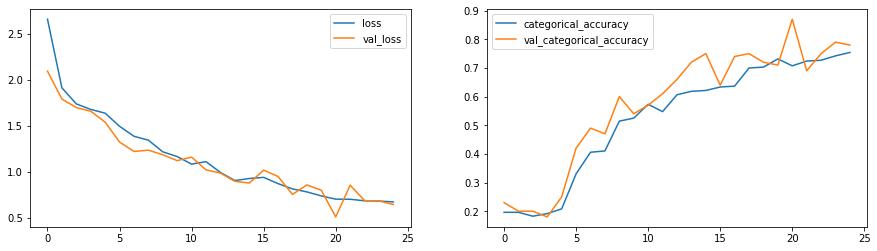

In [22]:
plot(history_3)



### Observation:

    Loss and Val loss looks good.
    But there is alot of fluctuation on accuracy graph.
    So in the next model we will increase the number of epochs and give more time to model for learning.



##  Model 4 (Using Conv3D)


In [23]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)
inputShape = batch_data[0].shape
inputShape

Source path =  Project_data/train ; batch size = 8


(15, 100, 100, 3)

In [24]:
train_path = data_loc+'/train'
val_path = data_loc+'/val'
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40
print ('# epochs =', num_epochs)


Input_shape = inputShape
model_3_1 = Sequential()
model_3_1.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=Input_shape))
#model_3_1.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model_3_1.add(Activation('relu'))
model_3_1.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3_1.add(Dropout(0.3))


model_3_1.add(Conv3D(32, (3, 3,3), padding='same'))
model_3_1.add(Activation('relu'))
model_3_1.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3_1.add(Dropout(0.3))

model_3_1.add(Conv3D(64, (3, 3,3), padding='same'))
model_3_1.add(Activation('relu'))
model_3_1.add(MaxPooling3D(pool_size=(2, 2,2)))
model_3_1.add(Dropout(0.2))



model_3_1.add(Flatten())
model_3_1.add(Dense(64,kernel_regularizer=l2(0.01)))
model_3_1.add(Activation('relu'))
model_3_1.add(Dropout(0.4))
model_3_1.add(Dense(128,kernel_regularizer=l2(0.01)))
model_3_1.add(Activation('relu'))
model_3_1.add(Dropout(0.4))

model_3_1.add(Dense(5))
model_3_1.add(Activation('softmax'))

optimiser =Adam(0.001) #write your optimizer
model_3_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3_1.summary())

# training sequences = 663
# validation sequences = 100
# epochs = 40
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_6 (Activation)   (None, 15, 100, 100, 16)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 7, 50, 50, 16)     0         
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 50, 50, 32)     13856     
                                                                 
 activation_7 (Activation)   (None, 7, 50, 50, 32)

In [25]:
# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)



model_name = 'Model_3_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
 

history_3_1 = model_3_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)   

Source path =  Project_data/train ; batch size = 8
Epoch 1/40
83/83 [==============================] - ETA: 0s - loss: 2.8673 - categorical_accuracy: 0.2308Source path =  Project_data/val ; batch size = 8
4

Epoch 00001: val_loss improved from inf to 2.31677, saving model to Model_3_1_2021-12-2610_09_20.878549\model-00001-2.86730-0.23077-2.31677-0.44000.h5
83/83 [==============================] - 66s 799ms/step - loss: 2.8673 - categorical_accuracy: 0.2308 - val_loss: 2.3168 - val_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 2/40
83/83 [==============================] - ETA: 0s - loss: 2.0534 - categorical_accuracy: 0.23684

Epoch 00002: val_loss improved from 2.31677 to 1.76758, saving model to Model_3_1_2021-12-2610_09_20.878549\model-00002-2.05341-0.23680-1.76758-0.41000.h5
83/83 [==============================] - 68s 827ms/step - loss: 2.0534 - categorical_accuracy: 0.2368 - val_loss: 1.7676 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 3/40
83/83 [======================

Epoch 17/40
83/83 [==============================] - ETA: 0s - loss: 0.5690 - categorical_accuracy: 0.86124

Epoch 00017: val_loss did not improve from 0.66581
83/83 [==============================] - 60s 734ms/step - loss: 0.5690 - categorical_accuracy: 0.8612 - val_loss: 0.6884 - val_categorical_accuracy: 0.8600 - lr: 2.5000e-04
Epoch 18/40
83/83 [==============================] - ETA: 0s - loss: 0.4826 - categorical_accuracy: 0.88994

Epoch 00018: val_loss did not improve from 0.66581

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
83/83 [==============================] - 61s 746ms/step - loss: 0.4826 - categorical_accuracy: 0.8899 - val_loss: 0.7739 - val_categorical_accuracy: 0.8500 - lr: 2.5000e-04
Epoch 19/40
83/83 [==============================] - ETA: 0s - loss: 0.4344 - categorical_accuracy: 0.91704

Epoch 00019: val_loss improved from 0.66581 to 0.64074, saving model to Model_3_1_2021-12-2610_09_20.878549\model-00019-0.43444-0.91704-0.64074-

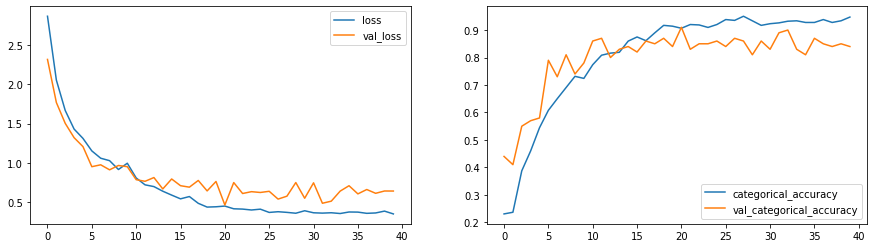

In [26]:
plot(history_3_1)



## Observation:

    Model is looks good.
    We have least number of fluctuation in the end.
    So far this is the best model using Conv3D.





## Now Lets try with Conv2D + RNN models.

Will use Tansfer Learnging + GRU for this Assignment.

## MODEL 5 (Tansfer Learning + GRU base model)

Will use the batch size as 16.

In [32]:
batch_size = 8

In [33]:
testGen = generator(train_path,train_doc,batch_size)
batch_data,batch_labels = next(testGen)
inputShape = batch_data[0].shape
inputShape

Source path =  Project_data/train ; batch size = 8


(15, 100, 100, 3)

In [34]:
train_path = data_loc+'/train'
val_path = data_loc+'/val'
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [35]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 1024)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 64)               

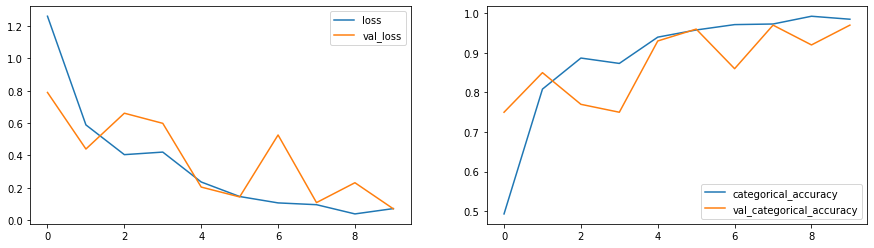

In [36]:
model_name = 'Model_3_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


# Model 1 (Transfer Learning + GRU) Basic
mobilenet_TL = mobilenet.MobileNet(weights='imagenet', include_top=False)
model_gru_1 = Sequential()
model_gru_1.add(TimeDistributed(mobilenet_TL,input_shape=inputShape))

model_gru_1.add(TimeDistributed(BatchNormalization()))
model_gru_1.add(TimeDistributed(MaxPooling2D((2, 2))))
model_gru_1.add(TimeDistributed(Flatten()))

model_gru_1.add(GRU(64))
model_gru_1.add(Dropout(0.3))

model_gru_1.add(Dense(64,activation='relu'))
model_gru_1.add(Dropout(0.3))

model_gru_1.add(Dense(5, activation='softmax'))

optimiser =Adam(0.001) #write your optimizer
model_gru_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_gru_1.summary())

# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

num_epochs=10
model_gru_1=model_gru_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, 
                    validation_data=val_generator,validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0)
plot(model_gru_1)

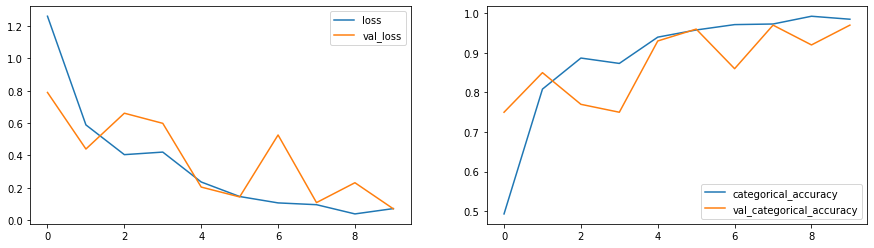

In [37]:
plot(model_gru_1)



## Observations:

    Getting approx 95 training accuracy and 92 validation accuracy.
    Will experiment by removing the dropout in the next model.



## MODEL 6 (Tansfer Learning + GRU)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 64)               

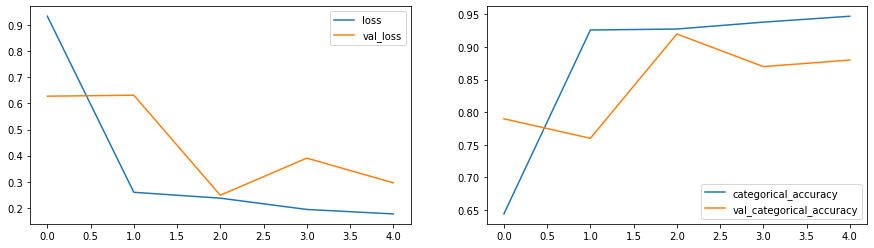

In [38]:
model_name = 'Model_TL_GRU_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


# Model 1 (Transfer Learning + GRU) Basic
mobilenet_TL = mobilenet.MobileNet(weights='imagenet', include_top=False)
model_gru_2 = Sequential()
model_gru_2.add(TimeDistributed(mobilenet_TL,input_shape=inputShape))

model_gru_2.add(TimeDistributed(BatchNormalization()))
model_gru_2.add(TimeDistributed(MaxPooling2D((2, 2))))
model_gru_2.add(TimeDistributed(Flatten()))

model_gru_2.add(GRU(64))
model_gru_2.add(Dropout(0.2))

model_gru_2.add(Dense(64,activation='relu'))

model_gru_2.add(Dense(5, activation='softmax'))

optimiser =Adam(0.001) #write your optimizer
model_gru_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_gru_2.summary())

# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

num_epochs=5
model_gru_2=model_gru_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, 
                    validation_data=val_generator,validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0)
plot(model_gru_2)

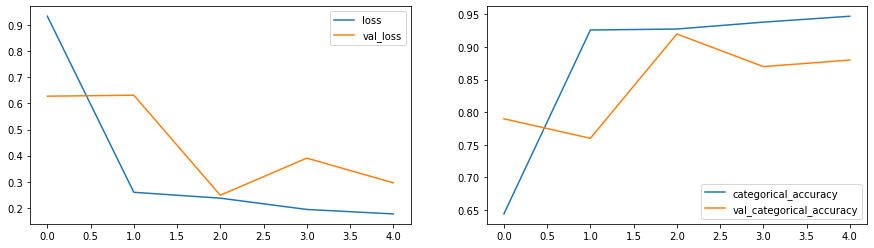

In [39]:
plot(model_gru_2)



## Observations:

    Not getting the clear picture by using 5 epochs.
    But model looks ok.



## MODEL 7 (Transfer Learning + GRU)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 15, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 gru_3 (GRU)                 (None, 64)               

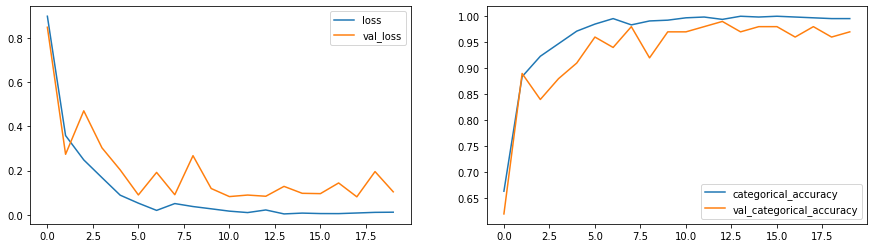

In [40]:
model_name = 'Model_TL_GRU_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


# Model 3 (Transfer Learning + GRU) Basic
mobilenet_TL = mobilenet.MobileNet(weights='imagenet', include_top=False)
model_gru_3 = Sequential()
model_gru_3.add(TimeDistributed(mobilenet_TL,input_shape=inputShape))

model_gru_3.add(TimeDistributed(BatchNormalization()))
model_gru_3.add(TimeDistributed(MaxPooling2D((2, 2))))
model_gru_3.add(TimeDistributed(Flatten()))

model_gru_3.add(GRU(64))
model_gru_3.add(Dropout(0.2))

model_gru_3.add(Dense(64,activation='relu'))

model_gru_3.add(Dense(5, activation='softmax'))

optimiser =Adam(0.001) #write your optimizer
model_gru_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_gru_3.summary())

# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

num_epochs=20
model_gru_3=model_gru_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, 
                    validation_data=val_generator,validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0)
plot(model_gru_3)

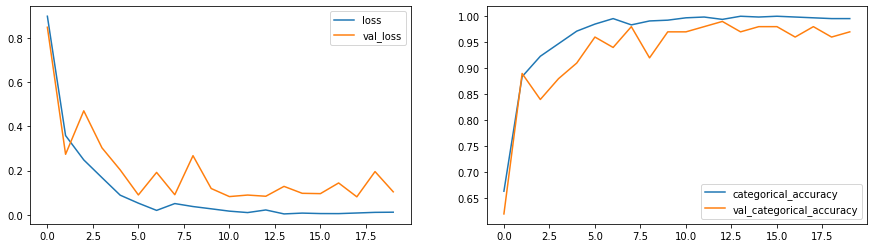

In [41]:
plot(model_gru_3)



## Observations:

    This model looks good.
    Taining Accuracy lies between: 95-98
    Validation Accuracy lies between: 92-95



## MODEL 8 (Transfer Learning + GRU)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 15, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 gru_4 (GRU)                 (None, 64)               

Epoch 13/20
83/83 [==============================] - ETA: 0s - loss: 0.1405 - categorical_accuracy: 0.95934
4

Epoch 00013: val_loss improved from 0.11205 to 0.09333, saving model to Model_TL_GRU_5_2021-12-2610_56_35.912215\model-00013-0.14047-0.95928-0.09333-0.96000.h5
83/83 [==============================] - 65s 789ms/step - loss: 0.1405 - categorical_accuracy: 0.9593 - val_loss: 0.0933 - val_categorical_accuracy: 0.9600 - lr: 2.5000e-04
Epoch 14/20
83/83 [==============================] - ETA: 0s - loss: 0.1351 - categorical_accuracy: 0.96384

Epoch 00014: val_loss improved from 0.09333 to 0.08597, saving model to Model_TL_GRU_5_2021-12-2610_56_35.912215\model-00014-0.13506-0.96380-0.08597-0.97000.h5
83/83 [==============================] - 64s 783ms/step - loss: 0.1351 - categorical_accuracy: 0.9638 - val_loss: 0.0860 - val_categorical_accuracy: 0.9700 - lr: 2.5000e-04
Epoch 15/20
83/83 [==============================] - ETA: 0s - loss: 0.0985 - categorical_accuracy: 0.98194

Epoch

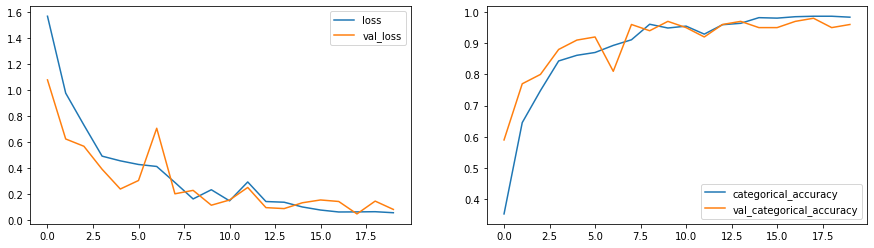

In [42]:
model_name = 'Model_TL_GRU_5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint,LR]


# Model 4 (Transfer Learning + GRU) Basic
mobilenet_TL = mobilenet.MobileNet(weights='imagenet', include_top=False)
model_gru_4 = Sequential()
model_gru_4.add(TimeDistributed(mobilenet_TL,input_shape=inputShape))

model_gru_4.add(TimeDistributed(BatchNormalization()))
model_gru_4.add(TimeDistributed(MaxPooling2D((2, 2))))
model_gru_4.add(TimeDistributed(Flatten()))

model_gru_4.add(GRU(64))
model_gru_4.add(Dropout(0.5))

model_gru_4.add(Dense(64,activation='relu'))
model_gru_4.add(Dropout(0.5))

model_gru_4.add(Dense(5, activation='softmax'))

optimiser =Adam(0.001) #write your optimizer
model_gru_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_gru_4.summary())

# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

num_epochs=20
model_gru_4=model_gru_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, 
                    validation_data=val_generator,validation_steps=validation_steps,class_weight=None, workers=1, initial_epoch=0)
plot(model_gru_4)

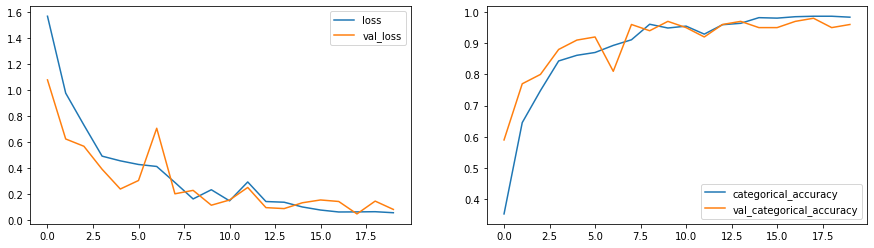

In [43]:
plot(model_gru_4)



## Observations:

    This model also looks good but not better than model 7.
    Taining Accuracy lies between: 94-97
    Validation Accuracy lies between: 88-92




## CONCLUSION :

So out of Conv3d and Conv2d+RNN we will go with the Conv2d+RNN which is Model 7 because of its higher accuracy and stability.
